In [ ]:
Compensation Analysis

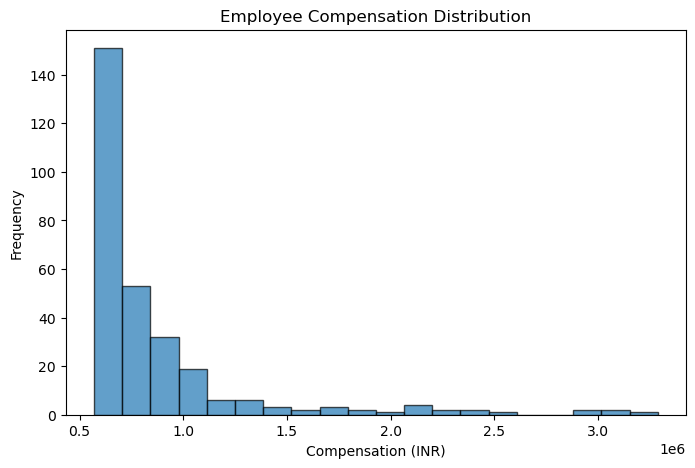

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load Excel File
excel_file = "Spaulding_Ridge_Case_Study_1.xlsx"

# Read and clean Employee Data
df_employee = pd.read_excel(excel_file, sheet_name='Employee Data', skiprows=1)
df_employee = df_employee.iloc[:, 1:]  # Dropping the first column
df_employee.columns = ['Name', 'Role', 'Location', 'Experience', 'Active', 'Compensation', 'Last_Working_Day']

# Read and clean Industry Compensation Data
df_industry = pd.read_excel(excel_file, sheet_name='Average Industry Compensation', skiprows=1)
df_industry = df_industry.iloc[:, 1:]  # Dropping the first column
df_industry.columns = ['Location', 'Role', 'Average_Compensation']

# Read and clean Employee Rating Data
df_rating = pd.read_excel(excel_file, sheet_name='Employee Rating', skiprows=1)
df_rating = df_rating.iloc[:, 1:]  # Dropping the first column
df_rating.columns = ['Name', 'Role', 'Location', 'Experience', 'Self_Rating', 'Manager_Rating']

# Compare Compensation Against Industry Benchmarks
df_merged = pd.merge(df_employee, df_industry, on=['Role', 'Location'])
df_merged['Compensation_Diff'] = df_merged['Compensation'] - df_merged['Average_Compensation']
df_merged['Flag'] = np.where(df_merged['Compensation_Diff'] < -50000, "Underpaid", "Fair/Overpaid")

# Merge Ratings Data
df_final = pd.merge(df_merged, df_rating, on=['Name', 'Role', 'Location'])

# Predict Future Compensation (Simple Linear Regression)
X = df_final[['Self_Rating', 'Manager_Rating']]
y = df_final['Compensation']
model = LinearRegression()
model.fit(X, y)
df_final['Predicted_Compensation'] = model.predict(X)

# Save Final Analysis
df_final.to_excel("Employee_Compensation_Analysis.xlsx", index=False)

# Visualize Compensation Distribution
plt.figure(figsize=(8, 5))
plt.hist(df_final['Compensation'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Compensation (INR)")
plt.ylabel("Frequency")
plt.title("Employee Compensation Distribution")
plt.show()

In [ ]:
Predictive Analysis

Raise recommendations exported to Raise_Recommendations.xlsx
Columns in df_predict: Index(['Name', 'Experience_x', 'Active', 'Compensation', 'Last_Working_Day',
       'Average_Compensation', 'Experience_y', 'Self_Rating', 'Manager_Rating',
       'Percent_of_Market', 'Raise_Flag', 'Role_Analyst', 'Role_Associate',
       'Role_Manager', 'Role_Senior Analyst', 'Role_Senior Associate',
       'Role_Senir Associate', 'Location_Banglore', 'Location_Jaipur',
       'Location_Pune'],
      dtype='object')
Features being used: ['Role_Analyst', 'Role_Associate', 'Role_Manager', 'Role_Senior Analyst', 'Role_Senior Associate', 'Role_Senir Associate', 'Location_Banglore', 'Location_Jaipur', 'Location_Pune', 'Experience_x', 'Self_Rating', 'Manager_Rating']
Mean Squared Error: 12449210598.647001
R-squared: 0.929978280582479
     Actual_Compensation  Predicted_Compensation       Residual  \
203            1884348.0            2.179981e+06 -295632.638726   
266             570000.0            5.6943

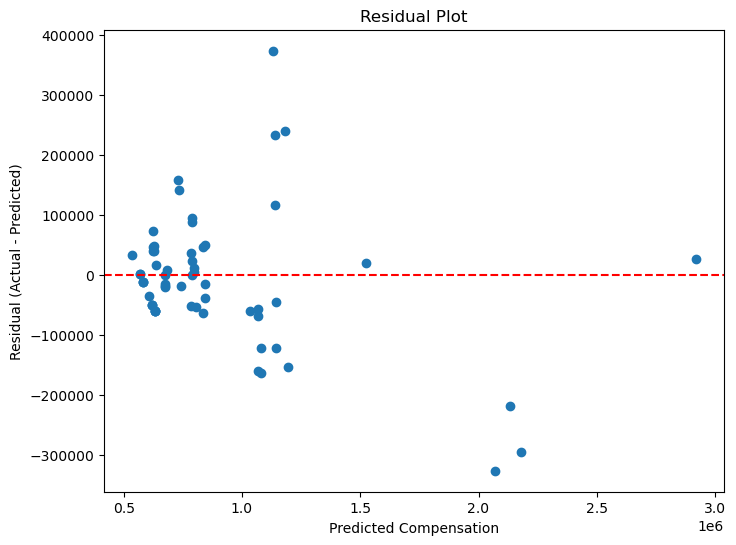

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Load Data (Simulating reading from MySQL)
excel_file = "Spaulding_Ridge_Case_Study_1.xlsx"  # Replace with your file path

df_employee = pd.read_excel(excel_file, sheet_name="Employee Data", skiprows=1).iloc[:, 1:]
df_employee.columns = ['Name', 'Role', 'Location', 'Experience', 'Active', 'Compensation', 'Last_Working_Day']

df_industry = pd.read_excel(excel_file, sheet_name="Average Industry Compensation", skiprows=1).iloc[:, 1:]
df_industry.columns = ['Location', 'Role', 'Average_Compensation']

df_rating = pd.read_excel(excel_file, sheet_name="Employee Rating", skiprows=1).iloc[:, 1:]
df_rating.columns = ['Name', 'Role', 'Location', 'Experience', 'Self_Rating', 'Manager_Rating']

# Procedure 2 - First Output: Flagging for Raise

# Merge Data
df_merged = pd.merge(df_employee, df_industry, on=["Role", "Location"], how="left")
df_merged = pd.merge(df_merged, df_rating, on=["Name", "Role", "Location"], how="left")

# Define Rule and Apply Logic
df_merged['Percent_of_Market'] = (df_merged['Compensation'] / df_merged['Average_Compensation']) * 100
df_merged['Raise_Flag'] = np.where(
    (df_merged['Manager_Rating'] >= 4) & (df_merged['Percent_of_Market'] < 90),
    'Recommend Raise',
    'No Recommendation'
)

# Export Recommendations
df_merged[['Name', 'Role', 'Location', 'Manager_Rating', 'Compensation', 'Average_Compensation', 'Percent_of_Market', 'Raise_Flag']].to_excel(
    "Raise_Recommendations.xlsx", index=False
)

print("Raise recommendations exported to Raise_Recommendations.xlsx")


# Procedure 2 - Second Output: Compensation Prediction

# Prepare Features
df_predict = df_merged.copy()  # Work on a copy to avoid modifying the original

# Encode Categorical Data
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_cols = ['Role', 'Location']
encoded_data = encoder.fit_transform(df_predict[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_data, index=df_predict.index, columns=encoded_cols)
df_predict = pd.concat([df_predict.drop(categorical_cols, axis=1), df_encoded], axis=1)


# Convert 'Experience_x' to Numerical
df_predict['Experience_x'] = df_predict['Experience_x'].astype(str).str.split('-').str[0].astype(float)


# Feature Selection
features = list(encoded_cols) + ['Experience_x', 'Self_Rating', 'Manager_Rating']  # Use encoded cols
# Print columns in df_predict to debug
print("Columns in df_predict:", df_predict.columns)
# Print features to be used
print("Features being used:", features)

# Check if 'Experience_x' is in df_predict
if 'Experience_x' not in df_predict.columns:
    print("'Experience_x' column not found in df_predict.  Exiting.")
    exit()


X = df_predict[features].fillna(0)  # Handle NaN (important for modeling)
y = df_predict['Compensation'].fillna(0) # Ensure no NaN in target


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Suggest Adjustments (Example - based on prediction error)
df_predictions = pd.DataFrame({'Actual_Compensation': y_test, 'Predicted_Compensation': y_pred})
df_predictions['Residual'] = df_predictions['Actual_Compensation'] - df_predictions['Predicted_Compensation']
df_predictions['Adjustment_Suggestion'] = np.where(
    df_predictions['Residual'] > 5000, 'Consider Increase',
    np.where(df_predictions['Residual'] < -5000, 'Consider Decrease', 'No Adjustment')
)

print(df_predictions.head())


# Visualize Prediction Accuracy (Residual Plot)
plt.figure(figsize=(8, 6))
plt.scatter(df_predictions['Predicted_Compensation'], df_predictions['Residual'])
plt.axhline(y=0, color='r', linestyle='--')  # Zero-error line
plt.xlabel("Predicted Compensation")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

In [ ]:
Performance and Trend Analysis

Analysis exported to Employee_Compensation_Analysis_prod1.xlsx


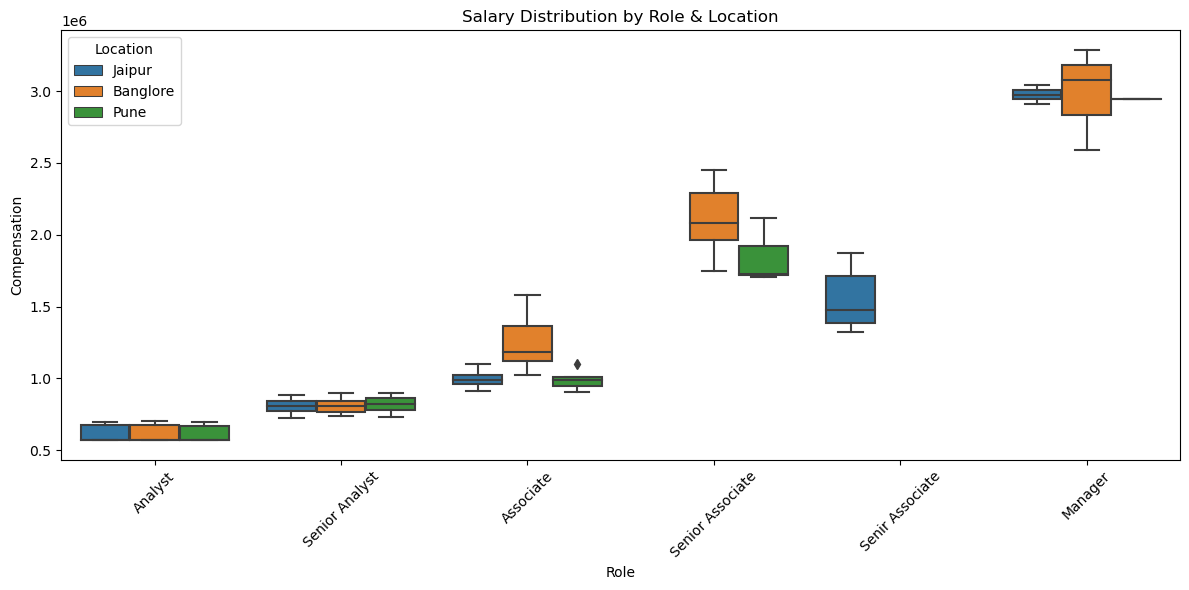

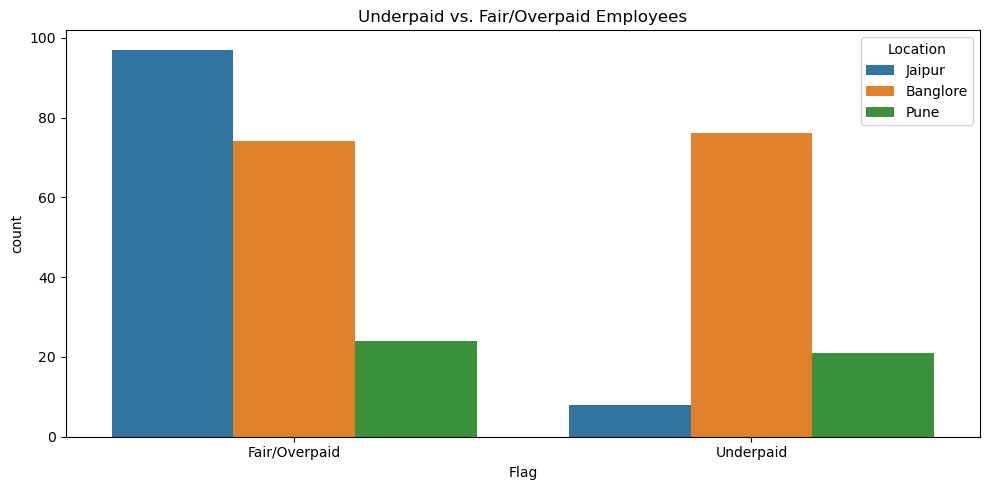

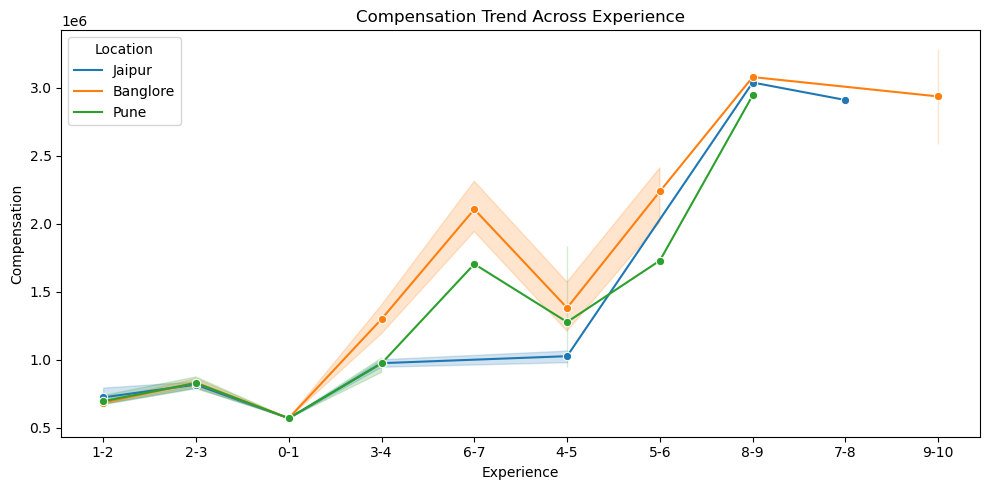

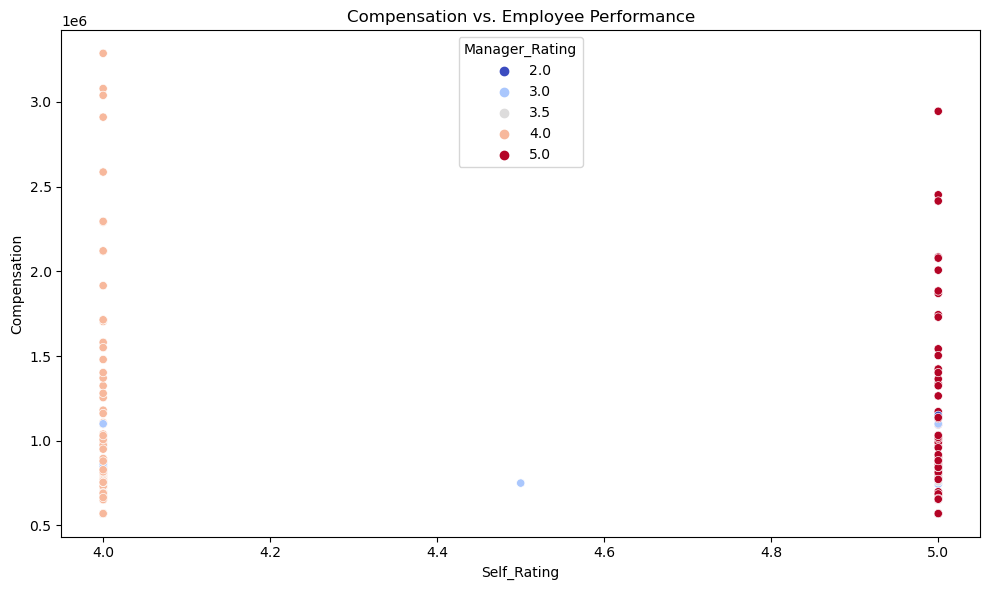

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# -----------------------------------------
# Configuration
# -----------------------------------------
EXCEL_FILE = "Spaulding_Ridge_Case_Study_1.xlsx"
OUTPUT_FILE = "Employee_Compensation_Analysis_prod1.xlsx"

# -----------------------------------------
# 1. Load & Clean Data
# -----------------------------------------
# Employee Data
df_employee = (
    pd.read_excel(EXCEL_FILE, sheet_name="Employee Data", skiprows=1)
      .iloc[:, 1:]
)
df_employee.columns = [
    'Name', 'Role', 'Location', 'Experience',
    'Active', 'Compensation', 'Last_Working_Day'
]

# Industry Compensation Data
df_industry = (
    pd.read_excel(EXCEL_FILE, sheet_name="Average Industry Compensation", skiprows=1)
      .iloc[:, 1:]
)
df_industry.columns = ['Location', 'Role', 'Average_Compensation']

# Employee Rating Data
df_rating = (
    pd.read_excel(EXCEL_FILE, sheet_name="Employee Rating", skiprows=1)
      .iloc[:, 1:]
)
df_rating.columns = [
    'Name', 'Role', 'Location',
    'Experience', 'Self_Rating', 'Manager_Rating'
]

# -----------------------------------------
# 2. Merge Employee + Industry
# -----------------------------------------
df_merged = pd.merge(
    df_employee,
    df_industry,
    on=["Role", "Location"],
    how="left"
)

# Compute compensation difference & flag underpaid
df_merged["Compensation_Diff"] = (
    df_merged["Compensation"] - df_merged["Average_Compensation"]
)
df_merged["Flag"] = np.where(
    df_merged["Compensation_Diff"] < -50000,
    "Underpaid",
    "Fair/Overpaid"
)

# -----------------------------------------
# 3. Merge in Ratings (keep Experience unambiguous)
# -----------------------------------------
df_final = pd.merge(
    df_merged,
    df_rating,
    on=["Name", "Role", "Location"],
    how="left",
    suffixes=("", "_rating")
)

# Optional: inspect columns
# print(df_final.columns.tolist())

# -----------------------------------------
# 4. Predict Future Compensation
# -----------------------------------------
X = df_final[["Self_Rating", "Manager_Rating"]]
y = df_final["Compensation"]

model = LinearRegression()
model.fit(X, y)
df_final["Predicted_Compensation"] = model.predict(X)

# -----------------------------------------
# 5. Save Final Analysis
# -----------------------------------------
df_final.to_excel(OUTPUT_FILE, index=False)
print(f"Analysis exported to {OUTPUT_FILE}")

# -----------------------------------------
# 6. Visualizations
# -----------------------------------------

# a) Salary Distribution by Role & Location
plt.figure(figsize=(12, 6))
sns.boxplot(x="Role", y="Compensation", hue="Location", data=df_final)
plt.title("Salary Distribution by Role & Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# b) Underpaid vs. Fair/Overpaid Flag Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x="Flag", hue="Location", data=df_final)
plt.title("Underpaid vs. Fair/Overpaid Employees")
plt.tight_layout()
plt.show()

# c) Compensation Trend Across Experience
plt.figure(figsize=(10, 5))
sns.lineplot(
    x="Experience",
    y="Compensation",
    hue="Location",
    data=df_final,
    marker="o"
)
plt.title("Compensation Trend Across Experience")
plt.tight_layout()
plt.show()

# d) Compensation vs. Performance Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Self_Rating",
    y="Compensation",
    hue="Manager_Rating",
    palette="coolwarm",
    data=df_final
)
plt.title("Compensation vs. Employee Performance")
plt.tight_layout()
plt.show()


In [ ]:
Employee Specific Compensation Analysis based on Performance and Trends 

Simple Linear Regression: MSE = 179782958905.76, R2 = -0.01
Polynomial Regression (Degree 2): MSE = 179233485492.61, R2 = -0.01


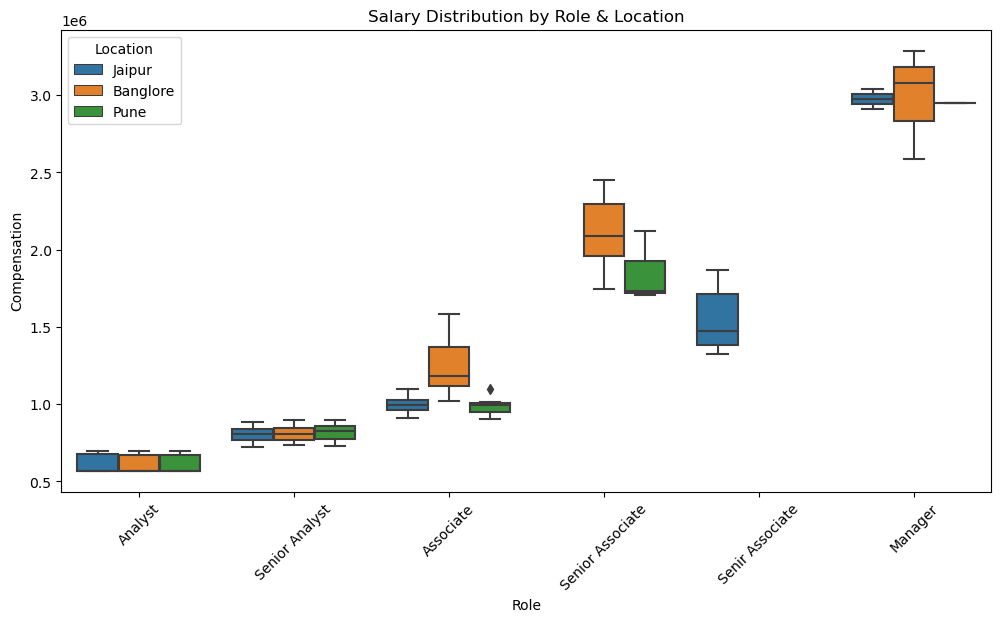

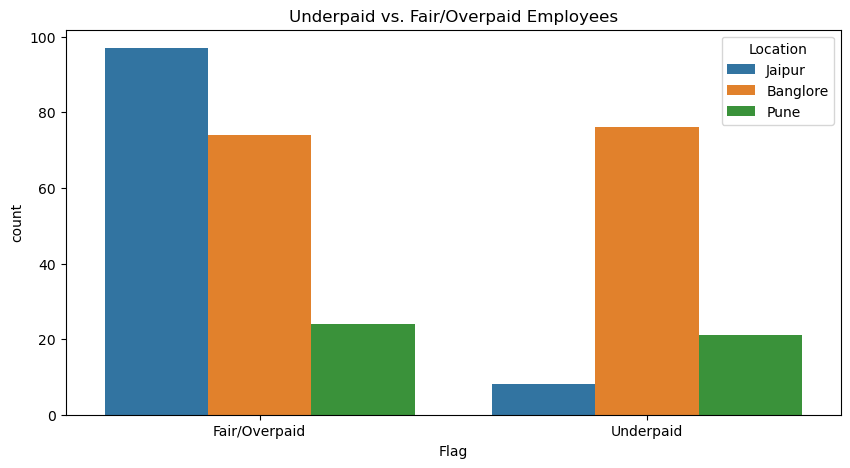

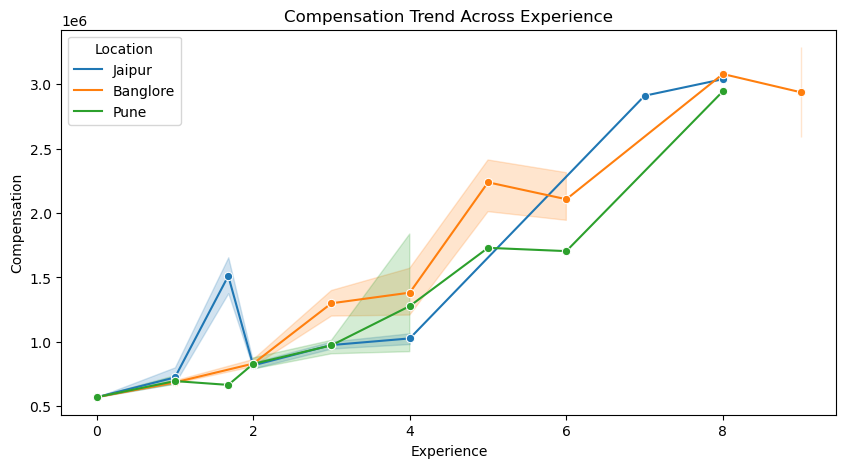

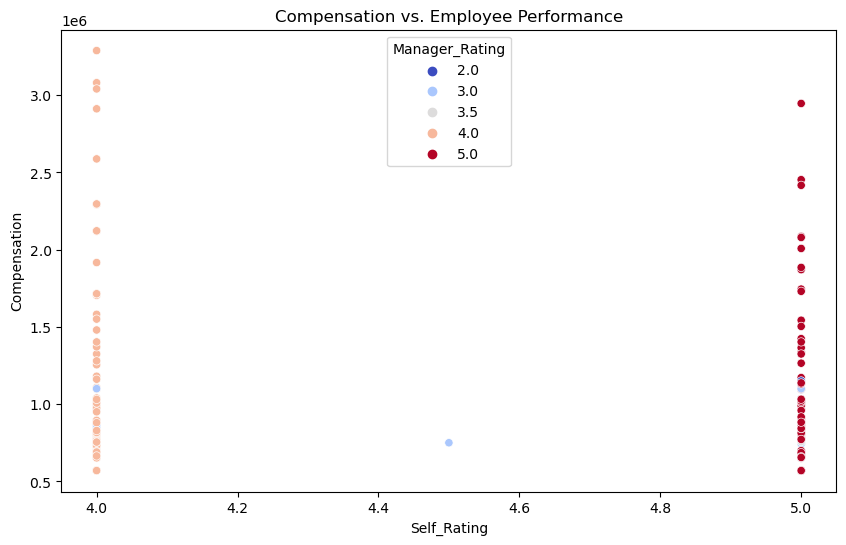


--- Underpaid Employees ---
                 Name            Role  Location  Experience  Compensation  \
1          Pooja Kaur  Senior Analyst  Banglore         2.0      798703.0   
4      Bilal Kulkarni       Associate    Jaipur         3.0      976125.0   
12         Hari Menon         Analyst      Pune         0.0      570000.0   
21      Damodar Kumar       Associate    Jaipur         4.0      910994.0   
23         Kunal Kaur         Analyst  Banglore         0.0      570000.0   
..                ...             ...       ...         ...           ...   
286       Neelam Kaur  Senior Analyst  Banglore         2.0      771600.0   
293   Ketaki Kulkarni         Analyst  Banglore         0.0      570000.0   
296  Khushi Chowdhury         Analyst  Banglore         0.0      570000.0   
297      Preethi Nair  Senior Analyst  Banglore         2.0      828900.0   
298      Pushpa Mehta       Associate  Banglore         4.0     1030381.0   

     Self_Rating  Manager_Rating  
1          

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def load_and_merge_data(excel_file):
    """
    Loads employee, industry compensation, and rating data from an Excel file,
    and merges them into a single DataFrame.

    Args:
        excel_file (str): Path to the Excel file.

    Returns:
        pd.DataFrame: Merged DataFrame containing all data.
    """
    try:
        # Load Employee Data
        df_employee = pd.read_excel(excel_file, sheet_name="Employee Data", skiprows=1).iloc[:, 1:].copy()  # Make a copy to avoid modifying original data
        df_employee.columns = ['Name', 'Role', 'Location', 'Experience', 'Active', 'Compensation', 'Last_Working_Day']

        # Load Industry Compensation Data
        df_industry = pd.read_excel(excel_file, sheet_name="Average Industry Compensation", skiprows=1).iloc[:, 1:].copy()
        df_industry.columns = ['Location', 'Role', 'Average_Compensation']

        # Load Employee Rating Data
        df_rating = pd.read_excel(excel_file, sheet_name="Employee Rating", skiprows=1).iloc[:, 1:].copy()
        df_rating.columns = ['Name', 'Role', 'Location', 'Experience', 'Self_Rating', 'Manager_Rating']

        # Merge Data with Industry Compensation
        df_merged = pd.merge(df_employee, df_industry, on=["Role", "Location"], how="left")
        df_merged["Compensation_Diff"] = df_merged["Compensation"] - df_merged["Average_Compensation"]
        df_merged["Flag"] = np.where(df_merged["Compensation_Diff"] < -50000, "Underpaid", "Fair/Overpaid")

        # Merge with Ratings Data
        df_final = pd.merge(df_merged, df_rating, on=["Name", "Role", "Location", "Experience"], how="left") # Added Experience in merge

        return df_final

    except FileNotFoundError:
        print(f"Error: File not found at {excel_file}")
        return None
    except KeyError as e:
        print(f"Error: Sheet not found in Excel file.  Check sheet names: {e}")
        return None
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        return None



def clean_data(df):
    """
    Cleans the input DataFrame by converting experience to numerical,
    rounding compensation, and filling missing values.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    df_cleaned = df.copy() # Create a copy to avoid modifying the original DataFrame
    try:
        # Convert 'Experience' to numerical, handling potential errors
        df_cleaned["Experience"] = df_cleaned["Experience"].astype(str).str.split("-").str[0].astype(float)
    except ValueError:
        print("Error: Could not convert 'Experience' to numerical. Please check the data format.")
        return None

    df_cleaned["Compensation"] = df_cleaned["Compensation"].round(0)
    # Fill missing values *after* experience conversion
    numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())
    return df_cleaned



def predict_compensation(df):
    """
    Predicts future compensation using Linear Regression and Polynomial Regression.

    Args:
        df (pd.DataFrame): DataFrame containing employee data.

    Returns:
        pd.DataFrame: DataFrame with predicted compensation.
    """
    df_predicted = df.copy() # Create a copy to avoid modifying the input DataFrame
    # Simple Linear Regression
    X = df_predicted[["Self_Rating", "Manager_Rating"]]
    y = df_predicted["Compensation"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #added train test split
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_simple = model.predict(X_test)
    df_predicted["Predicted_Compensation_Simple"] = model.predict(X) # Predict on the entire dataset

    # Evaluate Simple Linear Regression
    mse_simple = mean_squared_error(y_test, y_pred_simple)
    r2_simple = r2_score(y_test, y_pred_simple)
    print(f"Simple Linear Regression: MSE = {mse_simple:.2f}, R2 = {r2_simple:.2f}")

    # Polynomial Regression (Degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42) #added train test split
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train_poly)
    y_pred_poly = model_poly.predict(X_test_poly)
    df_predicted["Predicted_Compensation_Poly"] = model_poly.predict(poly.transform(X)) # Predict on the entire dataset

    # Evaluate Polynomial Regression
    mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
    r2_poly = r2_score(y_test_poly, y_pred_poly)
    print(f"Polynomial Regression (Degree 2): MSE = {mse_poly:.2f}, R2 = {r2_poly:.2f}")

    return df_predicted



def analyze_and_visualize(df):
    """
    Analyzes compensation, identifies underpaid employees, and generates visualizations.

    Args:
        df (pd.DataFrame): DataFrame containing employee data.
    """
    # Salary Distribution by Role & Location
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Role", y="Compensation", data=df, hue="Location")
    plt.title("Salary Distribution by Role & Location")
    plt.xticks(rotation=45)
    plt.show()

    # Underpaid vs. Fair Compensation Flag Distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x="Flag", hue="Location")
    plt.title("Underpaid vs. Fair/Overpaid Employees")
    plt.show()

    # Compensation vs. Experience
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="Experience", y="Compensation", hue="Location", marker="o")
    plt.title("Compensation Trend Across Experience")
    plt.show()

    # Salary vs. Performance Ratings
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="Self_Rating", y="Compensation", hue="Manager_Rating", palette="coolwarm")
    plt.title("Compensation vs. Employee Performance")
    plt.show()

    # Identify Underpaid Employees (using the 'Flag' column created earlier)
    underpaid_employees = df[df["Flag"] == "Underpaid"]
    print("\n--- Underpaid Employees ---")
    print(underpaid_employees[["Name", "Role", "Location", "Experience", "Compensation", "Self_Rating", "Manager_Rating"]])

    # Export to Excel
    df.to_excel("Employee_Compensation_Analysis.xlsx", index=False)
    print("\nAnalysis saved to Employee_Compensation_Analysis.xlsx")



def main(excel_file):
    """
    Main function to orchestrate the data loading, cleaning, prediction,
    analysis, and visualization process.

    Args:
        excel_file (str): Path to the Excel file.
    """
    df = load_and_merge_data(excel_file)
    if df is None:
        print("Exiting due to data loading errors.")
        return

    df_cleaned = clean_data(df)
    if df_cleaned is None:
        print("Exiting due to data cleaning errors.")
        return

    df_predicted = predict_compensation(df_cleaned)
    analyze_and_visualize(df_predicted)



if __name__ == "__main__":
    excel_file = "Spaulding_Ridge_Case_Study_1.xlsx" #changed the file name
    main(excel_file)


In [ ]:
Attrition Probability Analysis

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00         3

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Prioritization exported to Compensation_Adjustment_Priorities.xlsx


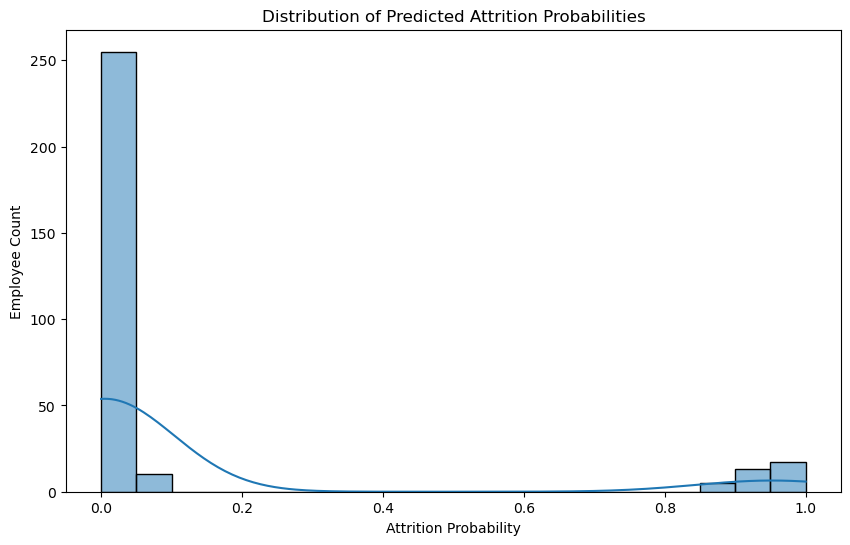

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Load Data from Excel
excel_file = "Spaulding_Ridge_Case_Study_1.xlsx"
df_employee = pd.read_excel(excel_file, sheet_name="Employee Data", skiprows=1).iloc[:, 1:]
df_employee.columns = ['Name', 'Role', 'Location', 'Experience', 'Active', 'Compensation', 'Last_Working_Day']

df_industry = pd.read_excel(excel_file, sheet_name="Average Industry Compensation", skiprows=1).iloc[:, 1:]
df_industry.columns = ['Location', 'Role', 'Average_Compensation']

df_rating = pd.read_excel(excel_file, sheet_name="Employee Rating", skiprows=1).iloc[:, 1:]
df_rating.columns = ['Name', 'Role', 'Location', 'Experience', 'Self_Rating', 'Manager_Rating']

# Merge Data
df = pd.merge(df_employee, df_industry, on=["Role", "Location"], how="left")
df = pd.merge(df, df_rating, on=["Name", "Role", "Location"], how="left")

# Label employees who left (Active = 'N') as 1, others as 0
df['Attrition'] = np.where(df['Active'] == 'N', 1, 0)

# Calculate compensation gap
df['Compensation_Gap'] = df['Compensation'] - df['Average_Compensation']

# Convert categorical data to numerical using OneHotEncoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_cols = ['Role', 'Location']
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_data, index=df.index, columns=encoded_cols)

# Combine encoded data with numerical features
df_final = pd.concat([df.drop(categorical_cols, axis=1), df_encoded], axis=1)

# Select features for classification
features = ['Compensation_Gap', 'Self_Rating', 'Manager_Rating'] + list(encoded_cols)
X = df_final[features].fillna(0)
y = df_final['Attrition']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict Attrition
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of leaving

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Add Predicted Attrition Probability for Current Employees
df['Attrition_Probability'] = model.predict_proba(X)[:, 1]

# Prioritize Compensation Adjustments Based on Attrition Risk
df_priority = df[df['Attrition'] == 0].sort_values(by='Attrition_Probability', ascending=False)
df_priority[['Name', 'Role', 'Location', 'Compensation', 'Compensation_Gap', 'Self_Rating', 'Manager_Rating', 'Attrition_Probability']].to_excel(
    "Compensation_Adjustment_Priorities.xlsx", index=False
)

print("Prioritization exported to Compensation_Adjustment_Priorities.xlsx")

# Visualization of Attrition Risk
plt.figure(figsize=(10, 6))
sns.histplot(df['Attrition_Probability'], bins=20, kde=True)
plt.title("Distribution of Predicted Attrition Probabilities")
plt.xlabel("Attrition Probability")
plt.ylabel("Employee Count")
plt.show()

In [ ]:
Salary Deviation Analysis

C:\Users\LAWRANCE\AppData\Local\Temp\ipykernel_11652\379259286.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.fillna(df_features.mean(numeric_only=True), inplace=True)


Recommendations exported to Compensation_Peer_Adjustments.xlsx


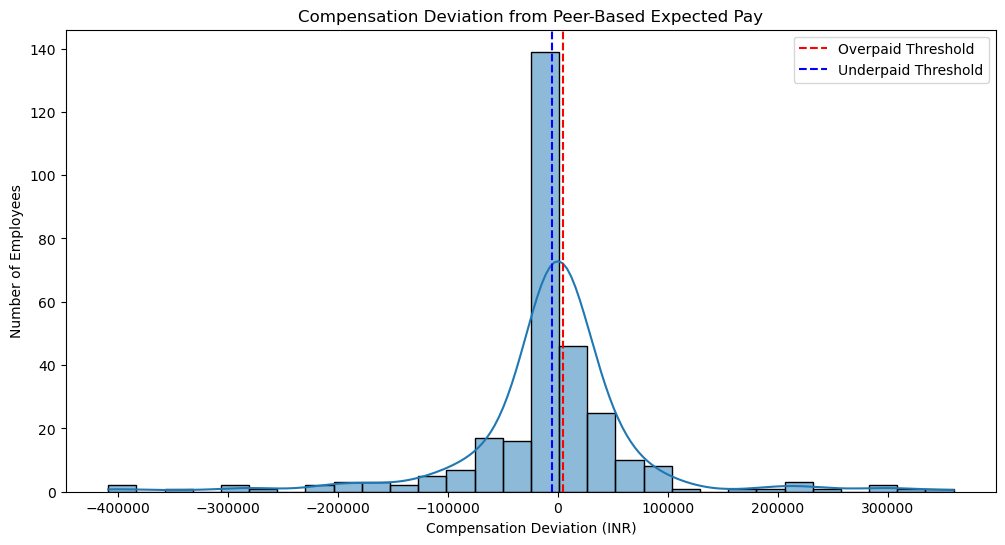

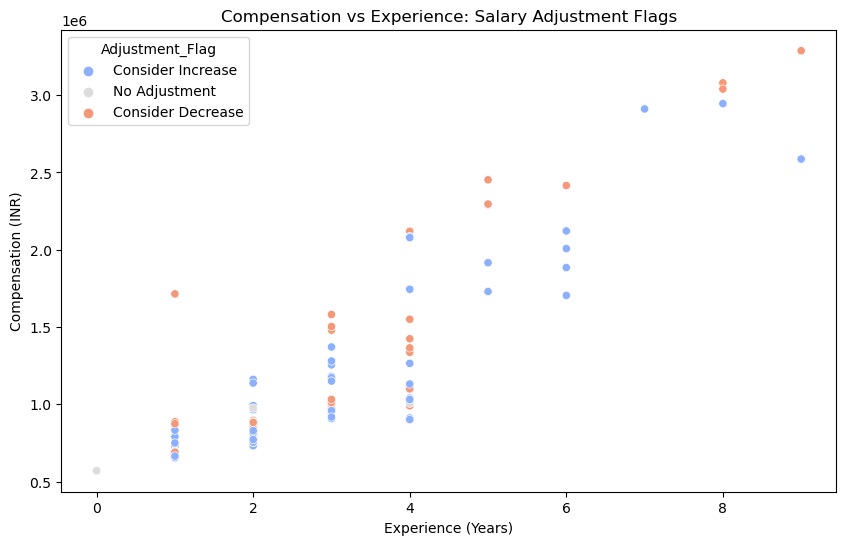

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Load Data from Excel
excel_file = "Spaulding_Ridge_Case_Study_1.xlsx"
df_employee = pd.read_excel(excel_file, sheet_name="Employee Data", skiprows=1).iloc[:, 1:]
df_employee.columns = ['Name', 'Role', 'Location', 'Experience_x', 'Active', 'Compensation', 'Last_Working_Day']

df_industry = pd.read_excel(excel_file, sheet_name="Average Industry Compensation", skiprows=1).iloc[:, 1:]
df_industry.columns = ['Location', 'Role', 'Average_Compensation']

df_rating = pd.read_excel(excel_file, sheet_name="Employee Rating", skiprows=1).iloc[:, 1:]
df_rating.columns = ['Name', 'Role', 'Location', 'Experience_y', 'Self_Rating', 'Manager_Rating']

# Merge Data
df = pd.merge(df_employee, df_industry, on=["Role", "Location"], how="left")
df = pd.merge(df, df_rating, on=["Name", "Role", "Location"], how="left")

# Convert experience columns separately
df["Experience_x"] = df["Experience_x"].astype(str).str.split("-").str[0].astype(float)
df["Experience_y"] = df["Experience_y"].astype(str).str.split("-").str[0].astype(float)

# Compute experience difference
df["Experience_Difference"] = df["Experience_x"] - df["Experience_y"]

# Encode Categorical Features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[['Role', 'Location']])
encoded_cols = encoder.get_feature_names_out(['Role', 'Location'])
df_encoded = pd.DataFrame(encoded_data, index=df.index, columns=encoded_cols)
df_final = pd.concat([df.drop(['Role', 'Location'], axis=1), df_encoded], axis=1)

# Select Features for Similarity Search
features = ['Experience_x', 'Experience_y', 'Experience_Difference', 'Self_Rating', 'Manager_Rating'] + list(encoded_cols)
df_features = df_final[features]

# Handle Missing Values Before Normalization
df_features.fillna(df_features.mean(numeric_only=True), inplace=True)

# Normalize Data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# Compute Cosine Similarity Matrix
df_scaled = np.nan_to_num(df_scaled)  # Replace NaN values before calculation
similarity_matrix = cosine_similarity(df_scaled)

# Find Top-N Peers Using k-NN
num_neighbors = 5
knn = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine')
knn.fit(df_scaled)
distances, indices = knn.kneighbors(df_scaled)

# Predict Expected Compensation Using Weighted Peers
expected_comp = []
for i in range(len(df)):
    peer_indices = indices[i]
    peer_comp = df.iloc[peer_indices]['Compensation']
    similarity_scores = distances[i]
    weighted_comp = np.average(peer_comp, weights=1 / (1 + similarity_scores))
    expected_comp.append(weighted_comp)

df['Expected_Compensation'] = expected_comp
df['Compensation_Deviation'] = df['Compensation'] - df['Expected_Compensation']

# Flag Employees for Adjustment
df['Adjustment_Flag'] = np.where(
    df['Compensation_Deviation'] > 5000, 'Consider Decrease',
    np.where(df['Compensation_Deviation'] < -5000, 'Consider Increase', 'No Adjustment')
)

# Export Recommendations
df[['Name', 'Role', 'Location', 'Experience_x', 'Experience_y', 'Experience_Difference', 'Compensation', 'Expected_Compensation', 'Compensation_Deviation', 'Adjustment_Flag']].to_excel(
    "Compensation_Peer_Adjustments.xlsx", index=False
)

print("Recommendations exported to Compensation_Peer_Adjustments.xlsx")

# **Visualization: Salary Deviation Analysis**
plt.figure(figsize=(12, 6))
sns.histplot(df['Compensation_Deviation'], bins=30, kde=True)
plt.axvline(x=5000, color='red', linestyle='dashed', label="Overpaid Threshold")
plt.axvline(x=-5000, color='blue', linestyle='dashed', label="Underpaid Threshold")
plt.title("Compensation Deviation from Peer-Based Expected Pay")
plt.xlabel("Compensation Deviation (INR)")
plt.ylabel("Number of Employees")
plt.legend()
plt.show()

# **Visualization: Compensation vs Experience Scatter Plot**
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Experience_x"], y=df["Compensation"], hue=df["Adjustment_Flag"], palette="coolwarm")
plt.title("Compensation vs Experience: Salary Adjustment Flags")
plt.xlabel("Experience (Years)")
plt.ylabel("Compensation (INR)")
plt.show()